# 10 class Classification Of Cells Using Logistic Regression

In [1]:
import sys
import os
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn

print('Python version     :', '{0[0]}.{0[1]}'.format(sys.version_info))
print('Tensorflow version :', tf.__version__)
print('numpy version      :', np.__version__)
np.random.seed(0)
tf.set_random_seed(2)

Python version     : 3.6
Tensorflow version : 1.4.0
numpy version      : 1.13.3


## Dataset

Our dataset consists of total of over 4,200 cells with a total of 10 categories;  
Each cell in the dataset is represented as a 2D matrix of transistor devices and their parameters given below:


| Device | param1 | param2 | param3 | param4 | param5 | ...... | ...... | param13 |
|--------|--------|--------|--------|--------|--------|--------|--------|---------|
|   10   |    6   |    6   |    3   |    3   |    5   |        |        |    2    |
|   10   |    8   |    3   |    2   |    4   |    4   |    2   |    3   |    6    |
|   20   |    7   |    3   |    2   |    4   |    4   |    2   |    3   |    2    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|   20   |    7   |    3   |    2   |    4   |    5   |    2   |    3   |    2    |


Entire dataset consists of 4,200 such tables is shown in the next picture.


![Cell Dataset As Stack Of Tables](https://github.com/srohit0/mida/blob/master/data/CellDatasetAsStackOfTables.jpg?raw=true)

# Load cells

1. Set parameters of the cells (like max devices and feature per device etc).
2. Read cells off the disk

In [2]:
# max_devices_per_cell is also max number of rows in circuit files in the training set
max_devices_per_cell = 369; 
# feature_per_device is different from max number of cols (14) in circuit files in training set
feature_per_device   = 5; 
feature_indices = (0,2,5,8,11)

def load_one_cell(cell_file):
    cell_cols = 14
    cell_data = np.zeros(shape=(max_devices_per_cell, cell_cols), dtype=np.float32)
    cell_mat  = np.loadtxt(cell_file, dtype=np.float32, ndmin=2)
    nrows     = cell_mat.shape[0]
    ncols     = cell_mat.shape[1]
    cell_data[:nrows, :ncols] = cell_mat
    cell_data = cell_data[:, feature_indices]
    return cell_data

In [3]:
def load_cells(folder):
  #Load the data for a single label.
  cell_files = os.listdir(folder)
  dataset = np.zeros(shape=(len(cell_files), max_devices_per_cell, feature_per_device),
                         dtype=np.float32)
  cell_index = 0
  for cell in cell_files:
    cell_file = os.path.join(folder, cell)
    try:
      cell_data = load_one_cell(cell_file)

      cell_rows = cell_data.shape[0]
      cell_cols = cell_data.shape[1]
      dataset[cell_index, :cell_rows, :cell_cols] = cell_data

      cell_index = cell_index + 1
    except IOError as e:
      print('Could not read:', cell_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:cell_index, :, :]

  print(os.path.basename(folder), ': shape=', dataset.shape, ', Mean=', np.mean(dataset), ', sigma=', np.std(dataset))
  return dataset

label_list = ['FDN', 'LD', 'ADDH', 'MAJ', 'AOA', 'ADDF', 'CKG', 'FDP', 'INV', 'EN']
n_labels   = len(label_list); # num_classes
for label_index in range(n_labels):
    cell_dataset = load_cells(os.path.join('..','data','cells',label_list[label_index]))
    cell_labels = np.zeros((cell_dataset.shape[0], n_labels))
    cell_labels[:, label_index] = 1
    if label_index:
        dataset = np.append(dataset, cell_dataset, axis=0)
        labels  = np.append(labels,  cell_labels,  axis=0)
    else:
        dataset = cell_dataset
        labels  = cell_labels

print('dataset: shape=', dataset.shape, ', Mean=', np.mean(dataset), ', sigma=', np.std(dataset))
print('labels : shape=', labels.shape)

FDN : shape= (192, 369, 5) , Mean= 0.867669 , sigma= 3.38401
LD : shape= (192, 369, 5) , Mean= 0.448001 , sigma= 2.27175
ADDH : shape= (208, 369, 5) , Mean= 0.57027 , sigma= 2.51812
MAJ : shape= (320, 369, 5) , Mean= 0.717342 , sigma= 2.72987
AOA : shape= (384, 369, 5) , Mean= 0.699328 , sigma= 2.90194
ADDF : shape= (464, 369, 5) , Mean= 1.71977 , sigma= 4.98359
CKG : shape= (560, 369, 5) , Mean= 1.47629 , sigma= 4.81816
FDP : shape= (608, 369, 5) , Mean= 0.777529 , sigma= 3.18849
INV : shape= (614, 369, 5) , Mean= 0.348261 , sigma= 2.0792
EN : shape= (736, 369, 5) , Mean= 0.850906 , sigma= 3.03733
dataset: shape= (4278, 369, 5) , Mean= 0.889867 , sigma= 3.45478
labels : shape= (4278, 10)


# Randomize Dataset

In [4]:
# randomize dataset and labels together to keep'em in sync.
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

# randomize dataset
dataset, labels = randomize(dataset, labels)

print('Full dataset: no. of cells=', dataset.shape, 'Min=', np.min(dataset), 'Max=',np.max(dataset), 
      'Mean=', np.mean(dataset), 'Sigma=', np.std(dataset))

Full dataset: no. of cells= (4278, 369, 5) Min= 0.0 Max= 50.0 Mean= 0.889867 Sigma= 3.45478


# Reformat Dataset

Reformat dataset so that it becomes consumable by the input layer of neural network.

In [5]:
def reformat(dataset):
    dataset = dataset.reshape((-1, max_devices_per_cell*feature_per_device))
    return dataset

dataset = reformat(dataset)
print(dataset.shape)

(4278, 1845)


# Normalize Dataset

In [6]:
# normalize the dataset between 0 and 1.
data_mean = 0;
data_std  = (np.max(dataset)-np.min(dataset));

def normalize(d, mean, std):
    return (d - mean) / std

def denormalize(d, mean, std):
    return (d * std) + mean

dataset = normalize(dataset, data_mean, data_std)

print('Min=', np.min(dataset), 'Max=',np.max(dataset), 'Mean=',np.mean(dataset), 'sigma=', np.std(dataset))
print('Dataset size', dataset.shape)
#print('dataset feature min vector = ', np.min(dataset, axis=0))
#print('dataset feature max vector = ', np.max(dataset, axis=0))

Min= 0.0 Max= 1.0 Mean= 0.0177973 sigma= 0.0690956
Dataset size (4278, 1845)


# Divide dataset
into training dataset and validation dataset

In [7]:
# training dataset percentage is 80%
def divide_dataset(dataset, labels):
    train_pct = 0.8; 
    # divide dataset into training and validation set
    train_index = int(dataset.shape[0]*train_pct)
    t_X = dataset[:train_index, :]
    t_Y = labels[:train_index,:]
    v_X = dataset[train_index:,:]
    v_Y = labels[train_index:,:]
    
    return t_X, t_Y, v_X, v_Y

train_X, train_Y, valid_X, valid_Y = divide_dataset(dataset, labels)

print(train_X.shape)

(3422, 1845)


## Declare Graph Variables

Place to declare place holders and variables for compute graph

In [8]:
SIGMA      = np.sqrt(2.0/train_X.shape[0])
n_features = train_X.shape[1]


Weights = tf.Variable(tf.truncated_normal(shape=[n_features, n_labels], mean=3.0*SIGMA, stddev=SIGMA, dtype=tf.float32), trainable=True)
Biases  = tf.Variable(tf.constant(value=SIGMA, dtype=tf.float32, shape=[n_labels]), trainable=True)

t_dataset = tf.placeholder(tf.float32, shape=(None, n_features), name='t_dataset');
t_labels  = tf.placeholder(tf.float32, shape=(None, n_labels), name='t_labels'); 

## Compute Graph
Construct a Logistic Regression model

In [9]:
predictions        = tf.matmul(t_dataset, Weights) + Biases

t_labels_cls       = tf.argmax(t_labels, axis=1)
predictions_cls    = tf.argmax(predictions, axis=1)
correct_prediction = tf.equal(predictions_cls, t_labels_cls)
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# change it to sigmoid_cross_entropy_with_logits
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=predictions,
                                                               labels=t_labels_cls)

## Parameters and Function
Logistic Regression parameters and functions

In [10]:
# Hyper parameters
# Parameters
learning_rate = 1
training_epochs = 500
display_step = 50

# Cost
cost = tf.reduce_mean(cross_entropy)

# Optimization algorithm
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

## Training the Model

In [11]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
sess = tf.Session()
sess.run(init)

t_start = datetime.now()

for epoch in range(training_epochs):
    sess.run(optimizer, feed_dict={t_dataset:train_X, t_labels:train_Y})

    #Display logs per epoch step
    if (epoch+1) % display_step == 0:
        t_cost, t_acc = sess.run([cost, accuracy], feed_dict={t_dataset:train_X, t_labels:train_Y})
        v_cost, v_acc = sess.run([cost, accuracy], feed_dict={t_dataset:valid_X, t_labels:valid_Y})
        print ("[", "{:4d}".format((datetime.now()-t_start).seconds), 
               "sec ] Epoch:", '%04d' % (epoch+1), 
               "cost=", "{:.5f}".format(t_cost),
               "train acc=", "{:.3f}".format(t_acc),
               "valid acc=", "{:.3f}".format(v_acc))

print( "\nOptimization Finished!" )

[    2 sec ] Epoch: 0050 cost= 1.55333 train acc= 0.467 valid acc= 0.460
[    4 sec ] Epoch: 0100 cost= 1.37214 train acc= 0.539 valid acc= 0.518
[    6 sec ] Epoch: 0150 cost= 1.26175 train acc= 0.600 valid acc= 0.574
[    8 sec ] Epoch: 0200 cost= 1.18245 train acc= 0.622 valid acc= 0.598
[   10 sec ] Epoch: 0250 cost= 1.12059 train acc= 0.647 valid acc= 0.611
[   13 sec ] Epoch: 0300 cost= 1.06992 train acc= 0.666 valid acc= 0.631
[   15 sec ] Epoch: 0350 cost= 1.02707 train acc= 0.680 valid acc= 0.644
[   17 sec ] Epoch: 0400 cost= 0.98999 train acc= 0.697 valid acc= 0.659
[   19 sec ] Epoch: 0450 cost= 0.95737 train acc= 0.711 valid acc= 0.668
[   21 sec ] Epoch: 0500 cost= 0.92829 train acc= 0.727 valid acc= 0.676

Optimization Finished!


# Cost and Accuracy

In [12]:
# Find cost on training dataset.
t_cost, t_acc = sess.run([cost, accuracy], feed_dict={t_dataset:train_X, t_labels:train_Y})
v_cost, v_acc = sess.run([cost, accuracy], feed_dict={t_dataset:valid_X, t_labels:valid_Y})

print ("Training   cost    =", t_cost)
print ("Validation cost    =", v_cost, '\n')
print("Training   Accuracy =", t_acc)
print("Validation Accuracy =", v_acc)

Training   cost    = 0.92829
Validation cost    = 0.980694 

Training   Accuracy = 0.726768
Validation Accuracy = 0.676402


# Confusion Matrix

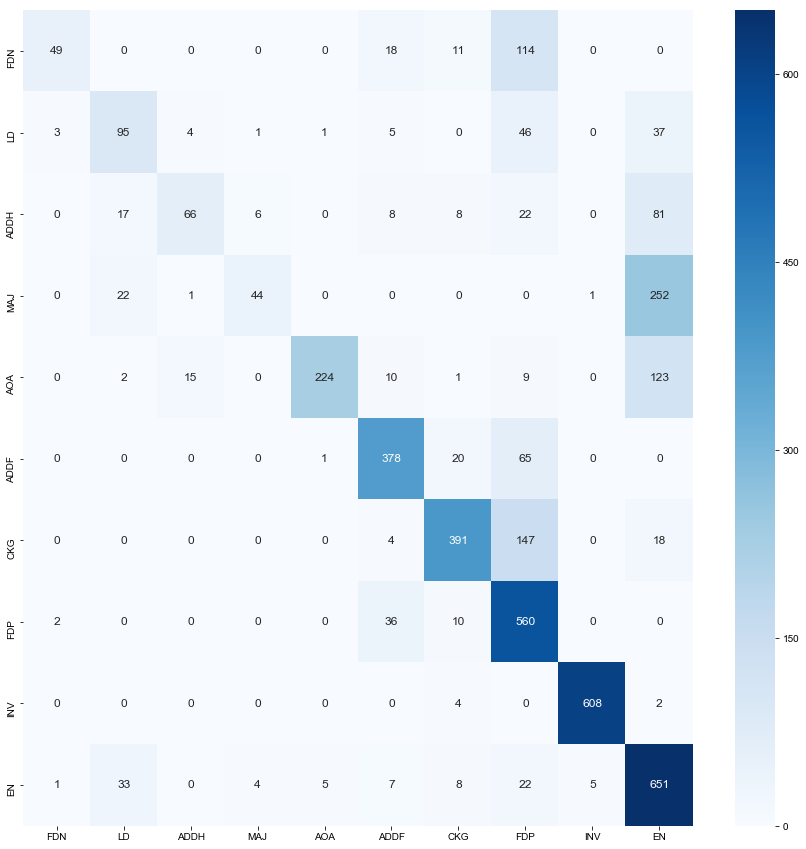

In [13]:
pred = sess.run(predictions, feed_dict={t_dataset:dataset, t_labels:labels})
cm = tf.confusion_matrix(labels=np.argmax(labels, axis=1), predictions=np.argmax(pred, axis=1), num_classes=n_labels)
cm_ary = cm.eval(session=sess)

plt.figure(figsize = (1.5*n_labels,1.5*n_labels))
sn.heatmap(cm_ary,   xticklabels=label_list, yticklabels=label_list,
           cmap="Blues", annot=True, fmt='d', annot_kws={"size": 12})# font size
sn.set(font_scale=1.0)#for label size
plt.show()

# Conclusion
Logistic Regression gave us unacceptable accuracy of around 70% in both training and validation sets.

In [14]:
sess.close()